# <font color=blue>OmegAlpes Tutorial 2 - Battery and shiftable consumption
`Prerequisite :` <a href="./OmegAlpes_Tutorial_1.ipynb">Tutorial 1</a><br><br>
<font color=red>There are some parts in this tutorial that has already been covered in previous Tutorial 1 and will not be covered here.</font>
    
    In this tutorial, we will learn to add storage unit and shiftable consumption unit. With these units, we will explore the suggestion to add battery and change his consumption pattern to John in order to reduce his electricity bill.
    
   `Learning outcomes :`
>1. New energy units: `StorageUnit` and `ShiftableConsumptionUnit`
2. Sum total energy of 2 energy units
3. Processing result of new energy units
   
    At the end of this tutorial, you will be able to find out how much battery and changing consumption pattern can reduce  grid import. 

<img src="./images/1-John house.JPG"><br>

In [1]:
from Python_Scripts.Omegalpes_tutorial_2 import *

    Similar to previous Tutorial 1. Try to have similar steps to have a good programming structure.

## Create time unit   

In [2]:
time = TimeUnit(periods=24*1, dt=1)

You are studying the period from 2018-01-01 00:00:00 to 2018-01-01 23:00:00


    where :
    dt = 1 hour / 60 minutes since all of the production and consumption data is in 1-hour timestep
    period = 24 hours. You can have longer period if the data is available.
    
`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.time">time module</a>

## Create empty model
    

In [3]:
model = OptimisationModel(time=time, name='tutorial_2')

  
`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.optimisation.model">model module</a>

## Create energy unit
    You already have the skill to create basic production and consumption units. To enhance your skill further, let's learn to create storage units and one of the variation of Variable energy unit, Shiftable consumption unit.

### Create fixed energy units

    Create PV production and house consumption which we have the data profile of.
    
    We are going to suggest John to change his consumption pattern by moving his washing machine usage habit at night-time  (green graph) to a more favorable time. Thus, We use consumption profile file without washing machine usage for fixed   consumption unit data reference.

<img src="./images/2-WM.JPG" width="550" height="150" alt="Graph is produced using OmegAlpes">
<br>

In [4]:
consumption_profile = open("data/house con 24 kwh wo wm.csv", "r")

house_cons_file = [p for p in map(float, consumption_profile)]

house_consumption = FixedConsumptionUnit(time, 'johns_consumption', p=house_cons_file, energy_type=elec)

Creating the johns_consumption.


In [5]:
pv_profile = open("data/pv prod 24 kwh.csv", "r")

pv_production_daily = [p for p in map(float, pv_profile)]

pv_production = FixedProductionUnit(time, name='pv_production', p=pv_production_daily ,energy_type=elec)

Creating the pv_production.


    Now, we have created 2 fixed energy units
<img src="./images/2-fixed_units.JPG" width="550" height="150">

### Create variable energy units
     We create VariableProductionUnit and VariableConsumptionUnit, that represent grid export-import.

In [6]:
grid_import = VariableProductionUnit(time, 'grid_import', energy_type=elec, p_min=0)

grid_export = VariableConsumptionUnit(time, 'grid_export', energy_type=elec, p_min=0)

Creating the grid_import.
Creating the grid_export.


    Now, we create ShiftableConsumptionUnit that represents washing machine. ShiftableConsumptionUnit is a consumption unit with shiftable consumption profile. So, washing machine power profile is shiftable during optimisation.
    
    First, We import the washing machine consumptions data from the csv file provided.

In [7]:
wm_profile = open("data/washer 24 kwh.csv", "r")

wm_cons_file = [p for p in map(float, wm_profile)]

wm_consumption = ShiftableConsumptionUnit(time, 'washing_machine_consumption', power_values=wm_cons_file,
                                          energy_type=elec)

Creating the washing_machine_consumption.


    This shiftable consumption unit has attributes :
    - time which refers to timeunit
    - label to show in the result
    - power_values = consumption profile to shift (kW)
    - energy_type = electrical
    
`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.energy_nodes">energy nodes module</a>

    Now, we have three 3 energy units to add to our model.
<img src="./images/2-variable_units.JPG" width="550" height="150">
<br>

### Create storage units
    (try to remove) Now, we introduce another energy units type to the model, storage units. Do you remember that we have energy surplus in tutorial 1 that was exported to the grid ? Do you know how much is it ? It is time for another challenge!

In [8]:
%run Python_Scripts/quiz/quiz_tutorial21

    Now, we want to store this surplus to battery during optimisation. We create Storage units for that. 

In [9]:
storage = StorageUnit(time, name='storage', pc_max=1, pd_max=1, soc_min=0.1, soc_max=0.9, self_disch=0.01, ef_is_e0=True)

Creating the storage.


    This storage unit has attributes :
    - time which refers to timeunit
    - label to show in the result
    - pc (Quantity) : charging power [kW]
    - pd (Quantity) : discharging power [kW]
    - set_soc_min (DynamicConstraint): constraining the energy to be above the value : soc_min*capacity
    - set_soc_max (DynamicConstraint): constraining the energy to be below the value : soc_max*capacity
      soc = state of charge, so we set min discharge level (energy left), and max charge level of the storage
    - ef_is_e0 (ExternalConstraint) : Imposing ef=e0 on the time period.
      ef (Quantity) : energy in the storage at the end of the time horizon, i.e. after the last time step [kWh]
      e0  : the energy state for t=0

`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.units.storage_units">storage units module</a>

    Now, we have storage unit component in our model as well
    
<img src="./images/2-storage_unit.JPG" width="550" height="150">
<br>

## Define model objective
    The objective is still the same since our goal is to reduce electricity bill by minimizing grid import 

In [10]:
grid_import.minimize_production()

    In this case, optimisation will consider multiple variable units we have (storage, shiftable units & grid import-export).

`learn more optimization objective functions for energy units:`<a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.units.production_units">production units module</a> & <a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.units.consumption_units"> consumption units module</a>

## Create energy nodes

In [11]:
elec_node = EnergyNode(time, name="electrical_node", energy_type=elec)

Creating the electrical_node.


    Then, we connect energy units to the energy node we create. Now, we have storage and washing machine units to add.

In [12]:
elec_node.connect_units(pv_production,house_consumption,grid_import, grid_export,storage,wm_consumption)

    Great! Now, we have created our energy system
<img src="./images/2-node.JPG" width="700" height="150">



`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/energy_package.html#module-omegalpes.energy.energy_nodes">energy nodes module</a>

## Add the energy nodes to the optimisation model
    Remember to check that the timeunit is the same for the model and all the units

In [13]:
model.add_nodes(elec_node)


--- Adding all variables to the model ---
Adding variable : pv_production_p
Adding variable : pv_production_e_tot
Adding variable : johns_consumption_p
Adding variable : johns_consumption_e_tot
Adding variable : grid_import_p
Adding variable : grid_import_e_tot
Adding variable : grid_import_u
Adding variable : grid_export_p
Adding variable : grid_export_e_tot
Adding variable : grid_export_u
Adding variable : storage_p
Adding variable : storage_e_tot
Adding variable : storage_u
Adding variable : storage_capacity
Adding variable : storage_e
Adding variable : storage_pc
Adding variable : storage_pd
Adding variable : storage_uc
Adding variable : storage_e_f
Adding variable : washing_machine_consumption_p
Adding variable : washing_machine_consumption_e_tot
Adding variable : washing_machine_consumption_u
Adding variable : washing_machine_consumption_start_up
Adding variable : washing_machine_consumption_power_values

--- Adding all objectives to the model ---
Adding objective : grid_import_



`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.optimisation.model">optimisation model</a>

## Launch the optimisation

In [14]:
model.solve_and_update()


 - - - - - RUN OPTIMIZATION - - - - - 
Resolution duration = 0.20986199378967285 seconds.

 - - - - - UPDATE RESULTS - - - - - 
Updating unit : electrical_node
Updating unit : pv_production
	Quantity : p
	Quantity : e_tot
Updating unit : johns_consumption
	Quantity : p
	Quantity : e_tot
Updating unit : grid_import
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : grid_export
	Quantity : p
	Quantity : e_tot
	Quantity : u
Updating unit : storage
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : capacity
	Quantity : e
	Quantity : pc
	Quantity : pd
	Quantity : uc
	Quantity : e_f
Updating unit : washing_machine_consumption
	Quantity : p
	Quantity : e_tot
	Quantity : u
	Quantity : start_up
	Quantity : power_values




`to learn more in detail` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.optimisation.model">optimisation model</a>

## Plot result


Preparing to plot the energetic flows through the node electrical_node.
	Add power from pv_production.
	Add power from johns_consumption.
	Add power from grid_import.
	Add power from grid_export.
	Add power from storage.
	Add power from washing_machine_consumption.


<module 'matplotlib.pyplot' from '/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/pyplot.py'>

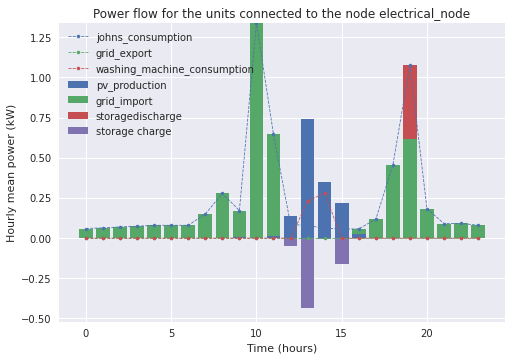

In [15]:
plot_node_energetic_flows(elec_node)

`learn more plotting functions:` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.utils.plots">plots module</a>

     Let us compare it with the input data we got
<img src="./images/2-WM.JPG" width="700" height="300" alt="Graph is produced using OmegAlpes">
<br>
    
    Let's review the changes!

In [17]:
%run Python_Scripts/quiz/quiz_review2

 What changes you observe from the result graph? 


RadioButtons(options=(('Grid Import', 1), ('Total consumption', 2), ('Energy surplus/Grid Export', 3)), value=…

Button(description='Review', style=ButtonStyle())

Output()

 ***
    Do you know what battery size is used in this optimisation? You can find out

In [18]:
storage.capacity.get_value()

0.77333333

 ***
    Since consumptions are seperated in two (house and washing machine), there is a way to sum them up using sum_quantities_in_quantity() function from OmegAlpes that enables you to to plot several quantities after the optimisation is done.
    
    Let's use below space to find the total consumption. replace a and b with appropriate argument

`learn more plotting functions:` : <a href="https://omegalpes.readthedocs.io/en/latest/api/general.html#module-omegalpes.general.utils.plots">plots module</a>
    


In [19]:
sum_quantities_in_quantity(quantities_list=[a,b])

NameError: name 'a' is not defined

    Did you manage to find total quantity of consumption ? Let's do this second challenge!

In [ ]:
%run Python_Scripts/quiz/quiz_tutorial22

## Discussion
    What do you think about the result? By adding storage and changing consumption pattern we are able to minimize import of the grid. Do you know how much import has been reduced? Try finding out yourself below and compare with previous result!

In [ ]:
sum(GRID_IMPORT.p.get_value())

    Let us return to the dashboard so we can progress more in finding optimal solution for John with the other level 2 Tuto-rial. Don't forget to collect 2 level 2 magic words in this tutorial by finishing tasks in order to unlock stuffs!
    
`[Link]` <a href="./OmegAlpes_tutorial.ipynb">Dashboard</a><br><br>